# Estimation d'un flux par machine learning

On se place sur l'intervalle $[0, 1]$. On suppose que l'on dispose d'une densité $u$ prenant les valeurs $0$ ou $1$ uniquement. 

On se donne une discrétisation de cet intervalle en $N$ mailles $T_i$, $i \in \{1, ..., N\}$, de même taille $\Delta x$ et on note $u_k$ la valeur moyenne de $u$ dans la maille $k$ pour $k$ dans $\{1, ..., N\}$.

Soit $\Delta t > 0$ un pas de temps donné. On considère une maille $T_i$ et une vitesse $\beta_i > 0$ sur le bord droit de la maille. On voudrait estimer la quantité de matière sortante de la maille $T_i$ pendant un temps $\Delta t$ avec un réseau de neuronne.

Les entrées du réseau sont :

- les fractions volumiques $u_{i-1}$, $u_i$, et $u_{i+1}$,
- la vitesse $\beta_i$.

et la sortie est la quantité de matière sortante.

Pour que l'estimation des paramètres du modèle fonctionne bien, il est préférable de "normaliser" les données d'entrées. Ici, les fractions volumiques sont comprises entre $0$ et $1$ mais la vitesse $\beta_i$ n'est pas bornée supérieurement, les mailles ont une taille $\Delta x$ et on regarde le flux sur un temps $\Delta t$.

Pour normaliser toutes ces données, on suppose que $\Delta t$ vérifie $\frac{\beta_i \Delta t}{\Delta x} \leq 1$. Ainsi, tout revient à considérer des mailles de tailles $1$, un pas de temps égal à $1$ et des vitesses $\frac{\beta_i \Delta t}{\Delta x}$ dans $[0, 1]$.

In [12]:
import keras.models
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

## Génération des données d'entraînement

Étant donné une maille, notre modèle retourne la quantité de matière sortante (un scalaire) du bord droit de la maille à partir des données d'entrées suivantes :

- la fraction volumique dans la maille de taille $1$ en question et celles des deux mailles adjacentes (trois valeurs entre 0 et 1)
- la vitesse sur le bord droit de la maille considérée (un scalaire dans $[0, 1]$)

Le modèle prend donc un vecteur 1D de $3 + 1$ éléments en entrée et retourne un scalaire (la quantité de matière).

1. Écrire une fonction `compute_volfrac` qui retourne les fractions volumiques dans un ensemble de mailles à partir de la position à laquelle la densité $u$ change de valeur (passage de 0 à 1 ou de 1 à 0). Elle prend en argument :
    
    - Un tableau 2D X contenant les coordonnées des bords gauche et droit de chaque maille dans lesquelles on veut calculer la fraction volumique $u_k$.
    - La position $\gamma$ du point de changement de valeur de $u$.
    - Une variable `side` telle que si `side` est négatif, $u$ vaut $1$ à gauche de $\gamma$ et $0$ à droite et le contraire si `side` est positif.

In [175]:
def compute_volfrac(X, gamma, side=-1):
    f = np.zeros((X.shape[0],1))
    if side <0 :
        for i in range(len(f)):
            deltax = X[i,1] - X[i,0]
            if X[i,0] < gamma and X[i,1] < gamma:
                f[i] = 1
            elif X[i, 0] < gamma < X[i, 1]:
                f[i] = (gamma - X[i,0])/deltax
            else: f[i] = 0

    else:
        for i in range(len(f)):
            deltax = X[i,1] - X[i,0]
            if X[i,0] < gamma and X[i,1] < gamma:
                f[i] = 0
            elif X[i, 0] < gamma < X[i, 1]:
                f[i] = (X[i,1] - gamma)/deltax
            else: f[i] = 1

    return f


In [183]:
# test question 1
gamma=-0.1 # gamma est entre -1/2 et 1/2 pour la suite
x = np.linspace(start=-1/2, stop=1/2, num=50)
X = np.zeros((len(x)-1, 2))
for i in range(len(X)):
    X[i,0] = x[i]
    X[i,1] = x[i+1]
fract = compute_volfrac(X, gamma,1)

In [184]:
x = np.linspace(start=-1/2, stop=1/2, num=50)
print(fract)

[[0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0.4]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]]


2. Écrire une fonction `compute_exact_mass` qui retourne la valeur exacte de la quantité de matière passant à travers le bord droit d'une maille à vitesse $\beta$. La fonction prend trois arguments d'entrée :

    - La position $\gamma$ comme dans la question précédente.
    - Une variable `side` comme dans la question précédente.
    - Une vitesse $\beta$ dans $[0, 1]$.

In [185]:
# gamma est entre -1/2 et 1/2 pour la suite

def compute_exact_mass(gamma, beta, side=-1):
    x = np.array([[-1/2, 1/2]])
    f = compute_volfrac(x,gamma, side=side)
    q_mat = f * beta
    if side < 0:
        if beta >=0:
            if beta <= 1/2 - gamma:
                q_mat = 0
            else:
                q_mat = beta - 1/2 + gamma
        else:
            q_mat = 0

    else:
        if beta < 0:
            q_mat = -beta
        else:
            if beta < 1/2 -gamma:
                q_mat = beta
            else:
                q_mat = 1/2 - gamma

    return q_mat * f

In [186]:
#test fonction compute_mass_exact
print(compute_exact_mass(gamma=-0.4, beta=-0.1))

[[0.]]


3. À l'aide des deux fonctions précédentes, écrire une fonction `generate_training_data` qui prend deux arguments `ngammas` et `nbetas` et retourne un dataset contenant des données d'entraînements. On prendra `ngammas` valeurs dans $[-1.5, 1.5]$ pour les positions $\gamma$ (ce qui recouvre les trois mailles de tailles 1), les deux valeurs $-1$ et $1$ pour la variable `side` afin d'avoir les deux configurations possibles et `nbetas` valeurs dans $[0, 1]$ pour les vitesses $\beta$. Le dataset retourné par cette fonction comportera donc `ngammas` x `nbetas` x $2$ éléments.

In [195]:
def generate_training_data(ngammas, nbetas):
    gamma_vect = np.random.uniform(-0.5, 0.5, size=ngammas)
    beta_vect = np.random.uniform(-1,1, size=nbetas)
    sides = np.array([-1,1])
    x = np.array([[-1/2, 1/2]])
    final_array = np.zeros((len(sides)*ngammas*nbetas, 3))
    cptr = 0
    for gamma in gamma_vect:
        for side in sides:
            for beta in beta_vect:
                final_array[cptr,:] = np.array([compute_volfrac(x,gamma,side), beta,
                                      compute_exact_mass(gamma, beta, side)])
                cptr += 1
    return final_array

## Estimation des paramètres du modèle

### Charger le dataset

4. Appeler la fonction `generate_training_data` et en afficher $5$ prises au hasard.

In [196]:
import random

In [197]:
ngammas = 80
nbetas = 80
sizetf = ngammas * nbetas * 2
batchsize = 100
trainarray = generate_training_data(ngammas, nbetas)
indices = random.sample(range(0, ngammas*nbetas*2), 5)
print(trainarray[indices, :], indices)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


[[ 0.87988008  0.73817908  0.64950907]
 [ 0.73632723  0.52572742  0.19295797]
 [ 0.40792547  0.79891719  0.08437639]
 [ 0.8056385   0.77485206  0.46766554]
 [ 0.91442332 -0.71652183  0.        ]] [8317, 6400, 12176, 12698, 1314]


5. Préparer le dataset pour l'entraînement du modèle (cache, shuffling, batch, prefetching, ...)

In [198]:
X = trainarray[:,:-1]
y =  trainarray[:,-1]
dataset = tf.data.Dataset.from_tensor_slices((X,y))
dataset = dataset.cache()
dataset = dataset.shuffle(sizetf, reshuffle_each_iteration=True)
dataset = dataset.batch(batchsize)

### Définition du modèle

6. Définir un modèle (comme vous voulez). Il prendra des tenseurs de taille 4 en entrée et retournera un tenseur de taille 1 en sortie.
7. Choisir une loss et un optimiseur adaptée à notre problème et compiler le modèle.

In [199]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [200]:
model = tf.keras.Sequential()
model.add(Dense(20, input_dim=2, activation='relu'))
model.add(Dense(10, input_dim=20, activation='relu'))
model.add(Dense(1, input_dim=10, activation='relu'))
model.compile(optimizer=Adam(learning_rate=1e-3), loss='MSE')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [201]:
nbepochs = 10
model.fit(dataset, epochs = nbepochs, verbose=1)

Epoch 1/10
128/128 [==============================] - 3s 26ms/step - loss: 0.0266
Epoch 2/10
  1/128 [..............................] - ETA: 16s - loss: 0.0177

2022-03-17 13:58:15.250599: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 8ms/step - loss: 0.0165
Epoch 3/10
  9/128 [=>............................] - ETA: 2s - loss: 0.0159 

2022-03-17 13:58:16.240495: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 6ms/step - loss: 0.0155
Epoch 4/10
  9/128 [=>............................] - ETA: 2s - loss: 0.0134 

2022-03-17 13:58:16.983907: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 8ms/step - loss: 0.0153
Epoch 5/10
  1/128 [..............................] - ETA: 16s - loss: 0.0168

2022-03-17 13:58:18.015362: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 8ms/step - loss: 0.0151
Epoch 6/10
  1/128 [..............................] - ETA: 19s - loss: 0.0151

2022-03-17 13:58:19.036439: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 8ms/step - loss: 0.0150
Epoch 7/10
  1/128 [..............................] - ETA: 16s - loss: 0.0163

2022-03-17 13:58:20.072044: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 9ms/step - loss: 0.0150
Epoch 8/10
  9/128 [=>............................] - ETA: 2s - loss: 0.0152 

2022-03-17 13:58:21.296586: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 7ms/step - loss: 0.0149
Epoch 9/10
 10/128 [=>............................] - ETA: 1s - loss: 0.0164 

2022-03-17 13:58:22.156210: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 9ms/step - loss: 0.0148
Epoch 10/10


2022-03-17 13:58:23.245490: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 [==============================] - 1s 7ms/step - loss: 0.0147


2022-03-17 13:58:24.188634: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


8. À l'aide de la fonction `save` du modèle, sauvegarder votre modèle entraîné. Vous pourrez ainsi le charger directement plus tard (ou le partager) avec la fonction `keras.models.load_model`.

In [202]:
model.save(filepath="/Users/theophilebaggio/Desktop/studies/Lyon_M2_SITN/Analyse_Appliquée_EDP/modeltheotp4")

INFO:tensorflow:Assets written to: /Users/theophilebaggio/Desktop/studies/Lyon_M2_SITN/Analyse_Appliquée_EDP/modeltheotp4/assets


In [203]:
from tensorflow.keras.models import load_model
model_test = load_model(filepath = "/Users/theophilebaggio/Desktop/studies/Lyon_M2_SITN/Analyse_Appliquée_EDP/modeltheotp4")

9. Étant donné une position $\gamma$ et un coté `side` pris au hasard, tracer sur un même graphique le résultat du modèle et les valeurs exactes pour des vitesses $\beta$ dans $[0, 1]$.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


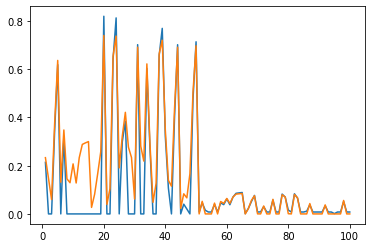

In [204]:
import matplotlib.pyplot as plt
dataset2 = generate_training_data(ngammas=1, nbetas=50)
Xtest = dataset2[:,:-1]
ytest = dataset2[:,-1]
res_model = model.predict(x=Xtest)
xgrid = range(1,len(ytest)+1)
plt.plot(xgrid, ytest)
plt.plot(xgrid, res_model)

### Évaluation du modèle

10. Tirer aléatoirement `ntests` données de test et évaluer votre modèle dessus.